# Spoiler reviews-Capstone

Authors: Gregor Habeck and Julia Schaefer

In [2]:
# import modules for data import and editing
import json
import pandas as pd
import gzip
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import time
import operator

# import modules for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#import modules for text analysis
import re

pd.set_option("display.max_columns", None)

We obtained the dataset from [UCSD Bookgraph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).  
We first write some functions to import the data. 

In [2]:
def import_json_gz(file,limit = 1000000):
    '''
    Function opens and loads a gziped json file and returns a selected number of rows from that file in tabular form.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    if limit > 1000000:
        return 'Sorry, your limit is to high. Please choose a number <= 1000000'
    data = []
    count = 0
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
            count += 1
            if count == limit:
                break
    f.close()
    return pd.DataFrame(data)

In [3]:
# to load the entire dataframe
def import_json_gz2(file):
    '''
    Function opens and loads a gziped json file. Use only for files smaller than 1 GB.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    data = []
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
    f.close()
    return pd.DataFrame(data)

In [85]:
# files that will be used
# file_meta contains meta data for books
file_meta = 'goodreads_books_meta.json.gz'
# file_review contains review texts and additional information
file_reviews = 'goodreads_reviews_spoiler.json.gz'
# file_genre contains genre of books
file_genre = 'goodreads_book_genres_initial.json.gz'

## Get meta data

In [86]:
#load a subset of the books meta data to get an idea of what features to extract
df_meta = import_json_gz(file_meta, 10000)

9999it [00:07, 1339.71it/s]


In [87]:
df_meta.head()

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,isbn,isbn13,kindle_asin,language_code,link,num_pages,popular_shelves,publication_day,publication_month,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,,"[{'author_id': '604031', 'role': ''}]",4.00,5333265,US,,,Paperback,https://images.gr-assets.com/books/1310220028m...,false,0312853122,9780312853129,,,https://www.goodreads.com/book/show/5333265-w-...,256,"[{'count': '3', 'name': 'to-read'}, {'count': ...",1,9,1984,St. Martin's Press,3,[],[],1,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,5400751
1,,"[{'author_id': '626222', 'role': ''}]",3.23,1333909,US,"Anita Diamant's international bestseller ""The ...",Abridged,Audio CD,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743509986,9780743509985,B000FC0PBC,,https://www.goodreads.com/book/show/1333909.Go...,,"[{'count': '2634', 'name': 'to-read'}, {'count...",1,10,2001,Simon & Schuster Audio,10,[],"[8709549, 17074050, 28937, 158816, 228563, 112...",6,Good Harbor,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,1323437
2,B00071IKUY,"[{'author_id': '10333', 'role': ''}]",4.03,7327624,US,Omnibus book club edition containing the Ladie...,Book Club Edition,Hardcover,https://images.gr-assets.com/books/1304100136m...,false,,,,eng,https://www.goodreads.com/book/show/7327624-th...,600,"[{'count': '58', 'name': 'to-read'}, {'count':...",,,1987,"Nelson Doubleday, Inc.",140,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",7,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,8948723
3,,"[{'author_id': '9212', 'role': ''}]",3.49,6066819,US,Addie Downs and Valerie Adler were eight when ...,,Hardcover,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743294297,9780743294294,B002ENBLOK,eng,https://www.goodreads.com/book/show/6066819-be...,368,"[{'count': '7615', 'name': 'to-read'}, {'count...",14,7,2009,Atria Books,51184,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",3282,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,6243154
4,,"[{'author_id': '149918', 'role': ''}]",3.40,287140,US,,,,https://images.gr-assets.com/books/1413219371m...,false,0850308712,9780850308716,,,https://www.goodreads.com/book/show/287140.Run...,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,,,,15,[],[],5,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,278577


We consider the following features as usful for EDA and feature engineering:  
    * book_id  
    * title  
    * description  
    * publication_year, publication_month, publication_day  
    * average_rating  
    * ratings_count  
    * num_pages  

Write some more functions to only import selected data. 

In [88]:
def check_features(features, dataset):
    '''
    simple way to check if selected features are in a dataset (dataset needs to be loaded)
    '''
    for f in features:
        if f not in dataset.columns:
            return f'{f} is not a valid column name'
    return 'Good to go!'

In [89]:
#generator to open json.gzip files
# yields single lines
def get_book(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l
    f.close()


# fetch features
def fetch_features(file, features, book_list):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    
    File: json.gzip file you want to scan
    
    Features: features to extract
    
    book_list: set of book_ids
    '''
    
    feature_dict = defaultdict(list)    
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        
        try:
            if book_id in book_list:
                for f in features:
                    feature_dict[f].append(book_dict.get(f))
        except: 
            pass
        
    return feature_dict

In [90]:
def fetch_one_feature(file, f):
    '''
    Provide a name of a feature you want to extract in a single run.
    Returns a list.
    '''
    
    feature = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        feature.append(book_dict.get(f))
    
    return feature

Firts we will check how many different books are reviews and on how many books we have metadata.

In [91]:
# import book ids as a measure of number of reviews
book_ids =fetch_one_feature(file_reviews, 'book_id')
print(f'Number of reviews: {len(book_ids)}')
# check how many different books are reviewed
book_ids=set(book_ids)
print(f'The dataset contains reviews for {len(book_ids)} books.')

1378033it [00:44, 31108.22it/s]

Number of reviews: 1378033
The dataset contains reviews for 25475 books.


In [92]:
# get book ids from review file
# features: list containing features we want to extract from the book-meta data file
features = ['book_id', 'title', 'description', 'publication_year', 'publication_month', 
            'publication_day', 'average_rating', 'ratings_count', 'num_pages']
check_features(features, df_meta)

'Good to go!'

In [93]:
#load meta-data for books that were reviewed in the review dataset
book_meta_features = pd.DataFrame.from_dict(fetch_features(file_meta, features, book_ids))

2360655it [03:22, 11654.20it/s]


In [94]:
# get a look at the metadata
book_meta_features.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,,,,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,,2009,2,1,3.64,3559,226


In [95]:
book_meta_features.shape

(25475, 9)

In [96]:
book_meta_features.isna().sum()

book_id              0
title                0
description          0
publication_year     0
publication_month    0
publication_day      0
average_rating       0
ratings_count        0
num_pages            0
dtype: int64

Going back to data source, we figured out that missing values are empty strings (''). We will use the replace function to replace missing values with np.nan.

In [97]:
# replace '' (missing values) with na
book_meta_features2 = book_meta_features.copy()
book_meta_features2 = book_meta_features2.replace('', np.nan)
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,NaN,2009,2,1,3.64,3559,226


In [98]:
#missing values
df_b_m = pd.DataFrame({
    'missing_count':book_meta_features2.isnull().sum()
})
df_b_m['missing_rel'] = round(df_b_m.missing_count/len(book_meta_features2),2)*100
df_b_m

,missing_count,missing_rel
book_id,0,0.0
title,0,0.0
description,305,1.0
publication_year,3084,12.0
publication_month,3605,14.0
publication_day,4183,16.0
average_rating,1,0.0
ratings_count,1,0.0
num_pages,2002,8.0


Information on publication dates is missing for approx. 15 % of the books. 

In [99]:
# what is the data type of the different features
# in the original data it looks like all features are saved as strings
book_meta_features.dtypes

book_id              object
title                object
description          object
publication_year     object
publication_month    object
publication_day      object
average_rating       object
ratings_count        object
num_pages            object
dtype: object

In [100]:
# replace average_rating, rating_count and num_pages as int
to_transform = ['publication_year','publication_month', 'publication_day','average_rating','ratings_count', 'num_pages' ]
for f in to_transform:
    book_meta_features2[f]=pd.to_numeric(book_meta_features2[f], errors='coerce')

In [101]:
book_meta_features2.dtypes

book_id               object
title                 object
description           object
publication_year     float64
publication_month    float64
publication_day      float64
average_rating       float64
ratings_count        float64
num_pages            float64
dtype: object

In [102]:
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008.0,6.0,1.0,3.41,3852.0,210.0
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011.0,6.0,7.0,3.98,252.0,8.0
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010.0,3.0,23.0,3.88,1675.0,245.0
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023.0,340.0
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017.0,3.0,5.0,4.36,1759.0,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012.0,1.0,1.0,4.10,289.0,402.0
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011.0,8.0,1.0,4.04,6049.0,400.0
9,9469517,Mercy,NaN,2009.0,2.0,1.0,3.64,3559.0,226.0


## Get genre information

Next we will extract the genre information. 

In [105]:
#load whole genre dataset
genre = import_json_gz2(file_genre)

2360655it [00:42, 55480.28it/s] 


In [106]:
genre.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [107]:
genre.shape

(2360655, 2)

The genre dataset contains genre information for 2.3 million books. However, according to the [data source](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews) we have reviews for 25k  books. We will use the function below to get the genres for the books contained in the review data set. Note that the genres are provided as a dictionary. The following function will also identify book_ids which have not been asigned a genre.

In [108]:
def fetch_genre(file, book_list):
    '''
    File: json.gzip file you want to scan
    
    book_list: set of book_ids
    
    Returns: list containing book_ids and genres and a list of book_ids with no information on genre
    '''
    
    book_genres = []    
    missing_genre = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        book_genre = book_dict.get('genres')
        try:
            if book_id in book_list:
                book_genres.append(book_dict) 
                # empty dictionary returns 
                if not book_genre:
                    missing_genre.append(book_id)
        except: 
            pass
        
    return book_genres, missing_genre

In [109]:
genre, missing_genre = fetch_genre(file_genre,book_ids)

2360655it [00:18, 128524.39it/s]


In [110]:
missing_genre

['16148398']

We only miss information for one of the books being reviews. As it is in the missing_genre_list only once we can also conclude that it has been reviewed only once. 

In [111]:
# write genre information to dataframe and get a look at it
df_genre = pd.DataFrame(genre)

In [112]:
df_genre.head()

,book_id,genres
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'..."
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,..."
2,2741853,"{'romance': 555, 'fiction': 61}"
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ..."
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri..."


In [113]:
df_genre.shape

(25475, 2)

In [114]:
# the genre dictionary ia based on vates by users
# function to get key from dictionary with highest value or ordered list
# returns None if dictionary is empty and max() will cause an error
def get_genre(x, output = 'max_vote'):
    try:
        
        a= max(x.items(), key=operator.itemgetter(1))[0]
        b = sorted(x.items(), key=operator.itemgetter(1))
        if output == 'max_vote':
            return a
        else:
            return b
    except:
        return np.nan

In [115]:
# create new colum containing genre with most votes (from users)
df_genre['best_genre'] = df_genre['genres'].apply(lambda x:get_genre(x))

In [116]:
df_genre.head()

,book_id,genres,best_genre
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'...",young-adult
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,...",romance
2,2741853,"{'romance': 555, 'fiction': 61}",romance
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ...",fiction
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri...",romance


In [117]:
# confirm that genre information is only missing for one book
df_genre.isnull().sum()

book_id       0
genres        0
best_genre    1
dtype: int64

In [118]:
# identify book with missing genre
df_missing_genre = df_genre[df_genre.best_genre.isnull()]
df_missing_genre

,book_id,genres,best_genre
16474,16148398,{},NaN


In [119]:
missing_book = book_meta_features2[book_meta_features2.book_id == '16148398']
missing_book

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
16474,16148398,Saga #1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We seem to have no information but the title for the book with the missing genre. Check how often this book was reviewd using the book ids.

In [120]:
i = 0
for book in book_ids:
    if book == '16148398':
        i += 1
print(f' The book "Saga #1" was reviewed {i} time(s)')

 The book "Saga #1" was reviewed 1 time(s)


As this book was only reviewed once, we might drop this review.

## Review data

No we will lokk at the reviews data.

In [122]:
# load the reviews data
t0 = time.time()
df_reviews = import_json_gz2(file_reviews)
elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

1378033it [11:48, 1944.18it/s] 


'00:12:23'

In [123]:
# get a quick look at the reviews data
df_reviews.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d
1,16981,False,3,a5d2c3628987712d0e05c4f90798eb67,"[[0, Recommended by Don Katz.], [0, Avail for ...",2017-03-22,8842281e1d1347389f2ab93d60773d4d
2,28684704,True,3,2ede853b14dc4583f96cf5d120af636f,"[[0, A fun, fast paced science fiction thrille...",2017-03-20,8842281e1d1347389f2ab93d60773d4d
3,27161156,False,0,ced5675e55cd9d38a524743f5c40996e,"[[0, Recommended reading to understand what is...",2016-11-09,8842281e1d1347389f2ab93d60773d4d
4,25884323,True,4,332732725863131279a8e345b63ac33e,"[[0, I really enjoyed this book, and there is ...",2016-04-25,8842281e1d1347389f2ab93d60773d4d


In [124]:
# merge datatframes (review data, book metadata, genre information) and put it all together
df_all = df_reviews.merge(book_meta_features2, on='book_id' ).merge(df_genre, on= 'book_id')
df_all.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,genres,best_genre
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
1,18245960,False,3,b88eb6519a046159a31afcc21a448b6f,"[[0, Average between the 4 star concepts (over...",2015-10-21,1a2398eca437fed5d9add310a0c09611,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
2,18245960,False,5,5ea837edf3b1386c613a123f46e1cccd,"[[0, A really refreshing take on science ficti...",2017-05-22,ab19fd8bcc1021d1c0f42dfa8d47f1e3,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
3,18245960,True,1,cefa3a787e1a845fb48acad37ff528de,"[[0, I'm really waffling between whether to ra...",2015-07-10,e956ca90ba23174bbbccf1161ab19150,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
4,18245960,True,5,86a7c0571fd59e729cf9e2340dda1224,"[[0, Every time I read a good science fiction ...",2016-07-30,da7a0c5ee0c89973224d8853445be68e,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction


In [125]:
# split into train, val and test dataset (70:20:10)
df_train, df_validate, df_test = \
              np.split(df_all.sample(frac=1, random_state=42), 
                       [int(.7*len(df_all)), int(.9*len(df_all))])

In [126]:
print(df_train.shape, df_validate.shape, df_test.shape)

(964623, 17) (275606, 17) (137804, 17)


In [ ]:
#save train, val and test dataset as json files
t0 = time.time()

df_train.to_json('training_set.json', orient = 'index')
df_validate.to_json('validation_set.json', orient = 'index')
df_test.to_json('test_set.json', orient = 'index')

elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [22]:
# test import 
t0 = time.time()
df_train = pd.read_json('training_set.json', orient = 'index')
elapsed_time = time.time()-t0
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


00:09:17


In [29]:
df_train.shape

(964623, 18)

In [7]:
# functions to isolate labels and text from review_sentences column
def get_sentence_label(x):
    return [label for label, text in x]
def get_sentence_text(x):
    return [text for label, text in x]


In [9]:
# extract sentence information (labels and text) into new colums of the dataframe
t0 = time.time()
df_train['sentence_labels'] = df_train.review_sentences.apply(lambda x: get_sentence_label(x))
t1 = time.time()
print(f'Time for extracting text: {time.strftime("%H:%M:%S", time.gmtime(t1-t0))}')
df_train['sentence_texts'] = df_train.review_sentences.apply(lambda x: get_sentence_text(x))
t2 = time.time()
print(f'time for extracting sentence labels: {time.strftime("%H:%M:%S", time.gmtime(t2-t1))}')
print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(t2-t0))}')

Time for extracting text: 00:01:14
time for extracting sentence labels: 00:00:14
Total time: 00:01:28


## Compare word frequency in spoiler reviews, spoiler sentences and reviews without spoiler

In [ ]:
df_spoiler_reviews = df_train[df_train['has_spoiler']==True]
df_no_spoiler_reviews = df_train[df_train['has_spoiler']==False]

In [30]:
spoiler_reviews = [r for r in df_spoilers.review_sentences]
safe_reviews = [r for r in df_no_spoilers.review_sentences]

In [3]:
# perform a spellcheck to reduce features using SymSpell
# to see generation of the custom_dictionary see notebook: spoiler_reviews_text_features_and_processing

import os
from symspellpy import SymSpell
#initiatae SmSpell with the custom  dictionary
custom_dictionary_path = os.path.abspath("custom_dictionary.txt") 
symspell = SymSpell()
#load dictionary
symspell.load_dictionary(custom_dictionary_path, term_index=0, count_index=1)

def spellcheck(text):
    '''
    function takes string as input, preprocesses text and returns a spellchecked text
    '''
    #preprocess text
    text = preprocessing(text)
    #hand to spellchecking and return the best result only if corrected phrase is more than just a single letter
    # otherwise continue
    sp = symspell.lookup_compound(text, max_edit_distance=1)
    if sp[0].term == None:
        return text
    else:
        return sp[0].term

In [288]:
# use only spoiler sentences
spoiler_text = []
for review in tqdm(spoiler_reviews):
    text = []
    for label, sentence in review:
        if label == 1:
            checked_text = spellcheck(sentence)
            text.append(checked_text)
        else:
            continue
    spoiler_text.append(' '.join(text))

100%|██████████| 62815/62815 [09:59<00:00, 104.79it/s]


In [47]:
# get entire text from reviews containing spoilers
spoiler_text_all = []
for review in tqdm(spoiler_reviews):
    text = []
    for label, sentence in review:
        
        checked_text = spellcheck(sentence)
        text.append(checked_text)
    spoiler_text_all.append(' '.join(text))

100%|██████████| 62815/62815 [28:11<00:00, 37.13it/s]  


In [48]:
# get reviews without spoilers 
# same number as spoiler reviews
safe_text = []
for review in tqdm(safe_reviews.iloc[len(df_spoiler_reviews)]):
    text = []
    for label, sentence in review:
        checked_text = spellcheck(sentence)
        text.append(checked_text)
    safe_text.append(' '.join(text))

100%|██████████| 62815/62815 [14:23<00:00, 72.75it/s] 


In [13]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

def lemmatizer(text):
    '''
    tokenizes string input using spacy 
    removes english stopwords
    '''
    doc = nlp_spacy(text)
    text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return text

In [291]:
# join review texts into one string
# lemmatize to reduce features further

spoilers = ' '.join([lemmatizer(text) for text in tqdm(spoiler_text)])
no_spoilers = ' '.join([lemmatizer(text) for text in tqdm(safe_text)])
spoilers_all = ' '.join([lemmatizer(text) for text in tqdm(spoiler_text_all)])

100%|██████████| 62815/62815 [46:32<00:00, 22.50it/s]  


In [269]:
# use Counter to get counts of lemmas

freq_spoiler = Counter(spoilers.split())
freq_no_spoiler = Counter(no_spoilers.split())
freq_spoiler_all = Counter(spoilers_all.split())

In [423]:
check for count of a single word
word = 'kill'
print(f'Count of {word} in no spoiler reviews:{freq_no_spoiler[word]}')
print(f'Count of {word} in spoiler sentences: {freq_spoiler[word]}')
print(f'Count of {word} in spoiler reviews: {freq_spoiler_all[word]}')

Count of kill in no spoiler reviews:369
Count of kill in spoiler sentences: 764
Count of kill in spoiler reviews: 1189


Even though this is just based on a selection, the word kill, which we assume to appear in spoilers, appears more often in spoiler sentences and spoiler reviews than in safe reviews. Within a spoiler review, kill is mentioned in spoiler sentences at a rate of 64%. 

In [285]:
# get total number of different lemmas in the combined strings
print(f'Length of no spoiler reviews:{len(freq_no_spoiler.keys())}')
print(f'Length of spoiler sentences:{len(freq_spoiler.keys())}')
print(f'Length of spoiler reviews:{len(freq_spoiler_all.keys())}')


Length of no spoiler reviews:17581
Length of spoiler sentences:14797
Length of spoiler reviews:22825


In [410]:
# get the top 100 lemmas and their counts associated with every text class
spoiler_top100 = sorted(freq_spoiler.items(), key=operator.itemgetter(1))[-100:]
no_spoiler_top100 = sorted(freq_no_spoiler.items(), key=operator.itemgetter(1))[-100:]
spoiler_all_top100 = sorted(freq_spoiler_all.items(), key=operator.itemgetter(1))[-100:]

In [411]:
#make a list containign the top 100 words in each text class
wordlist_top1000 = list(set(
    [word for word, c in spoiler_top100]+
    [word for word, c in no_spoiler_top100]+
    [word for word, c in spoiler_all_top100]))

In [412]:
len(wordlist_top100)

124

The top 100 wordlist set contains 124 different word lemmas suggesting that there are class specific words for the three classes in the top 100 - but that does also not exclude that these words are present in the reviews at lower frequency.

In [413]:
# calculate length of lemmatized input texts
spoiler_length = len(spoilers.split())
no_spoiler_length = len(no_spoilers.split())
spoilers_all_length = len(spoilers_all.split())

In [414]:
#calculate frequency of lemmas per 1000000
spoiler_freq = [] 
no_spoiler_freq = []
spoiler_all_freq = []
for word in wordlist_top100:
    spoiler_freq.append(freq_spoiler[word]/spoiler_length*1000000)
    no_spoiler_freq.append(freq_no_spoiler[word]/no_spoiler_length*1000000)
    spoiler_all_freq.append(freq_spoiler_all[word]/spoilers_all_length*1000000)

In [415]:
#make a dataframe with word frequncy for words
df_word_freq = pd.DataFrame({
    'words': wordlist_top100,
    'freq_in_spoiler_sentences': spoiler_freq,
    'freq_in_no_spoiler_reviews': no_spoiler_freq,
    'freq_in_spoiler_reviews':spoiler_all_freq
}) 

In [416]:
df_word_freq.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews
0,maybe,133.784838,109.695995,121.473953
1,bad,209.468832,186.525874,209.437849
2,real,110.468052,135.946204,122.333185
3,say,249.222041,158.995168,206.430537
4,break,114.290476,80.244541,76.149454


In [417]:
# normalize count data and safe to new dataframe
from sklearn import preprocessing
X = df_word_freq.iloc[:,1:].values
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df_word_freq_norm = pd.DataFrame(df_word_freq.words)
df_count_norm = pd.DataFrame(X_scaled, columns = ['freq_in_spoiler_sentences','freq_in_no_spoiler_reviews', 'freq_in_spoiler_reviews'])

In [418]:
df_word_freq_norm = pd.concat([df_word_freq_norm, df_count_norm], axis = 1, sort = False)
df_word_freq_norm.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews
0,maybe,0.093791,0.031832,0.031769
1,bad,0.159181,0.063752,0.076399
2,real,0.073646,0.042738,0.032205
3,say,0.193527,0.052314,0.074873
4,break,0.076948,0.019596,0.008773


In [419]:
df_word_freq_norm['sp_sentences_vs_minus_spoiler_reviews'] = df_word_freq_norm.freq_in_spoiler_sentences - \
df_word_freq_norm.freq_in_no_spoiler_reviews
df_word_freq_norm['sp_reviews_vs_minus_spoiler_reviews'] = df_word_freq_norm.freq_in_spoiler_reviews - \
df_word_freq_norm.freq_in_no_spoiler_reviews

In [420]:
df_word_freq_norm.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews,sp_sentences_vs_minus_spoiler_reviews,sp_reviews_vs_minus_spoiler_reviews
0,maybe,0.093791,0.031832,0.031769,0.061959,-0.000062
1,bad,0.159181,0.063752,0.076399,0.095429,0.012647
2,real,0.073646,0.042738,0.032205,0.030908,-0.010533
3,say,0.193527,0.052314,0.074873,0.141213,0.022559
4,break,0.076948,0.019596,0.008773,0.057353,-0.010822


In [422]:
# find words more common in spoiler sentences than in no spoiler texts
df_word_freq_norm.sort_values('sp_sentences_vs_minus_spoiler_reviews', ascending=False).head(20)

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews,sp_sentences_vs_minus_spoiler_reviews,sp_reviews_vs_minus_spoiler_reviews
78,like,1.000000,0.467459,0.623072,0.532541,0.155614
98,end,0.616579,0.153396,0.240968,0.463183,0.087572
120,think,0.589168,0.244458,0.318293,0.344710,0.073835
10,know,0.546896,0.219365,0.259659,0.327531,0.040294
43,go,0.466645,0.171396,0.219552,0.295249,0.048156
8,love,0.680317,0.422770,0.425426,0.257547,0.002656
50,thing,0.420079,0.180706,0.235954,0.239373,0.055249
24,feel,0.459049,0.223976,0.266852,0.235073,0.042876
18,get,0.355020,0.132116,0.164296,0.222904,0.032181
23,die,0.236460,0.016404,0.034712,0.220056,0.018308


Based on the standardized word frequency there seems to be only a small difference between spoiler texts and non-spoiler text. However, in the sentences containing spoilers, same words seem to appear at higher frequency. We might therefor use a sentence based approach rather than using the whole reviews.

## Word Importance using Naive Bayes

We will use multinomial naive bayes to find most important words to predict spoiler sentences.

### Single word in spoiler sentences
spoiler reviews only: safe vs. spoiler sentences in Spoiler reviews

In [69]:
#extract sentences and labels from 20000 spoiler reviews
sentences = []
labels = []

for review in tqdm(spoiler_reviews[:20000]):
    for label, sen in review:
        labels.append(label)
        sentences.append(spellcheck(sen))


100%|██████████| 20000/20000 [09:34<00:00, 34.82it/s]


In [ ]:
# number of timesa word has to occur
min_df = 1
# ngram_range (1,1) only one word (2,2):only bigrams
ngram_range = (1,1)

# CountVectorizer converts strings to matrix with 
# rows: observations 
# columns: words 
# values: number of occurences in observation
vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words = 'english', min_df = min_df) 

X = vectorizer.fit_transform(np.array(sentences))
y = np.array(labels)
clf = MultinomialNB(alpha = 1e-10)
clf.fit(X,y)

In [ ]:
df_likelihood = pd.DataFrame({
    'proba_in_no_spoiler':np.e**(clf.feature_log_prob_[0]),
    'proba_in_spoiler':np.e**(clf.feature_log_prob_[1]),
    'relative_probability_spoiler': np.e**(clf.feature_log_prob_[1]) - np.e**(clf.feature_log_prob_[0])
    },index = vectorizer.get_feature_names())
df_likelihood.sort_values('relative_probability_spoiler', ascending = False).head(10)

In [ ]:
top10 = df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[:10]
bottom10=df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[-10:]
top_bottom10 = pd.concat([top10, bottom10])

plt.figure(figsize=(9,7))
ax = sns.barplot(x = top_bottom10.relative_probability_spoiler, y = top_bottom10.index, palette = 'BrBG' )

__Note that this is preliminary and based on a selection of the reviews containing spoilers.__
* Words like end, kill and death are the most important words to distinguish sentences containing spoilers from sentences not containing spoilers within a review containing spoilers.  
* try with lemmatization and removing stopwords using other libraries
* try with bigrams
* test TF-IDF

In [62]:
# function to plot results of mulinomial Bayes calculation of feature importance
def important_features_MB(text_list,labels, ngram = (1,1), min_df = 500, vectorizer = 'T', stop_words = 'english'):
    if vectorizer == 'T':
        vec = TfidfVectorizer(ngram_range=ngram,stop_words = stop_words, min_df = min_df)
    elif vectorizer == 'C':
        vec = CountVectorizer(ngram_range=ngram,stop_words = stop_words, min_df = min_df)
    else:
        return "Wrong input: Please use 'C' or 'T' for count- or TFIDF vectorizer"

    X = vec.fit_transform(np.array(text_list))
    y = np.array(labels)
    clf = MultinomialNB(alpha = 1e-10)
    clf.fit(X,y)

    df_likelihood = pd.DataFrame({
        'proba_in_no_spoiler':np.e**(clf.feature_log_prob_[0]),
        'proba_in_spoiler':np.e**(clf.feature_log_prob_[1]),
        'relative_probability_spoiler': np.e**(clf.feature_log_prob_[1]) - np.e**(clf.feature_log_prob_[0])
        },index = vec.get_feature_names())

    top10 = df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[:10]
    bottom10=df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[-10:]
    top_bottom10 = pd.concat([top10, bottom10])

    plt.figure(figsize=(9,7))
    ax = sns.barplot(x = top_bottom10.relative_probability_spoiler, y = top_bottom10.index, palette = 'BrBG' )
    plt.show(ax)

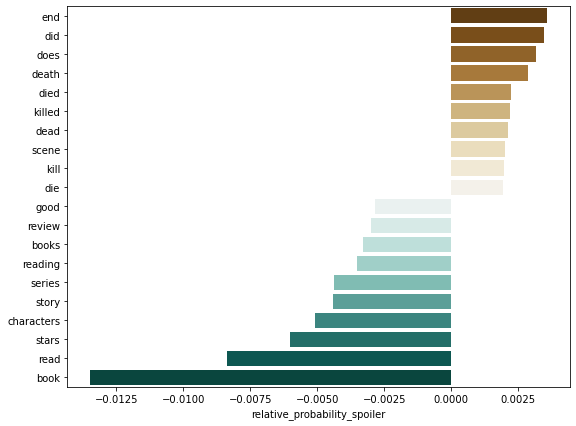

In [76]:
# same as above but TFIDF vectorizer
important_features_MB(sentences, labels,vectorizer = 'T')

### Word importance after lemmatization

In [699]:
# lemmatize input sentences
sentences_l = [lemmatizer(sen) for sen in sentences]

In [24]:
#write lemmatized sentences to file as this took forever
#with open('lemmatized_spoiler_review_sentences.txt', 'w+') as new_file:
#    for sen in sentences_l:
#        new_file.write(f'{sen}\n')
#new_file.close()
with open('lemmatized_spoiler_review_sentences_labels.txt', 'w+') as new_labels:
    for l in labels:
        new_labels.write(f'{l}\n')
new_labels.close()

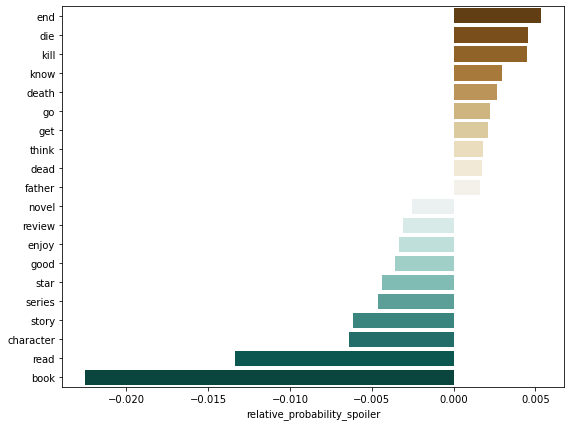

In [66]:
# word importance after lemmatization using Countvectorizer
important_features_MB(sentences_l, labels,vectorizer = 'C', stop_words = None)

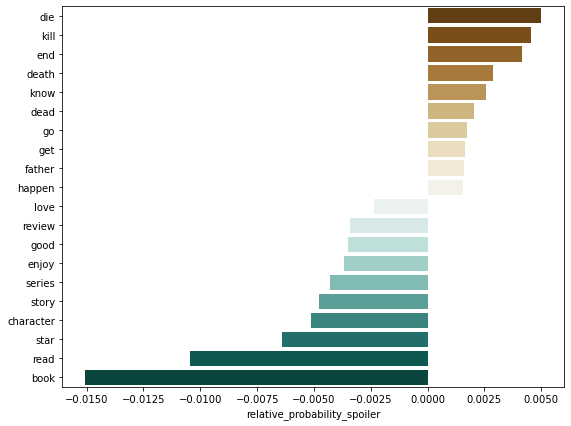

In [67]:
# test with TF-IDF
important_features_MB(sentences_l, labels,vectorizer = 'T', stop_words = None)

#### Word importance of linked words

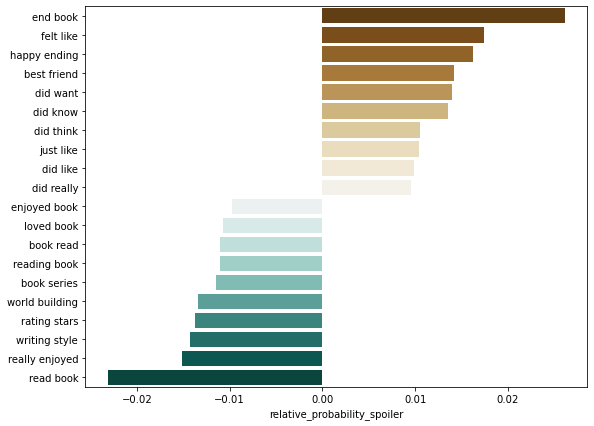

In [77]:
#calculate feature importance for bigrams (ngram = (2,2))
#use spellchecked sentences as input
important_features_MB(sentences, labels,vectorizer = 'C', stop_words = 'english', ngram = (2,2))

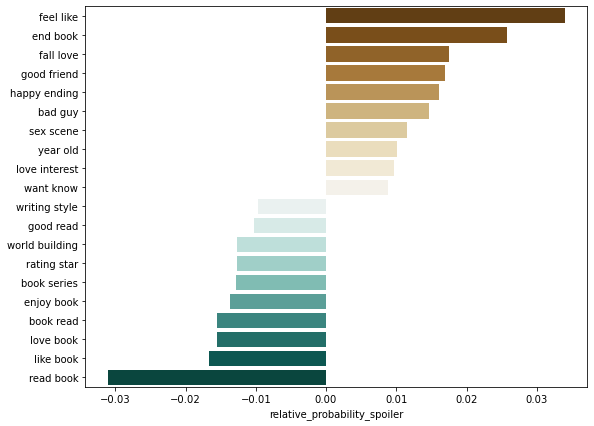

In [78]:
#calculate feature importance for bigrams (ngram = (2,2))
#use lemmatized sentences woithout stopwords and TFIDF vectorizer
important_features_MB(sentences_l, labels,vectorizer = 'T', stop_words = None, ngram = (2,2))

This semes to make a lot of scence: Phrases like 'end book', 'happy ending', 'fall (in) love' are things we can envision as spoiling a book. On the other side, 'read book', 'writing style', 'book series' are general terms.

### Word importance comparing entire reviews
__spoiler reviews vs non-spoiler reviews__

In [49]:
reviews = safe_text + spoiler_text_all
labels_all = [0]*len(safe_text) + [1]*len(spoiler_text_all)


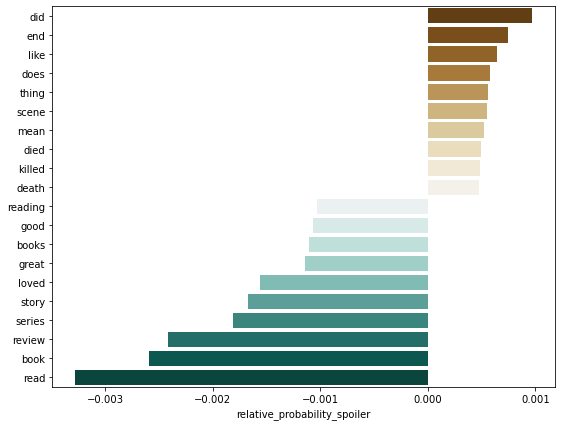

In [79]:
#importance of single words
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (1,1))

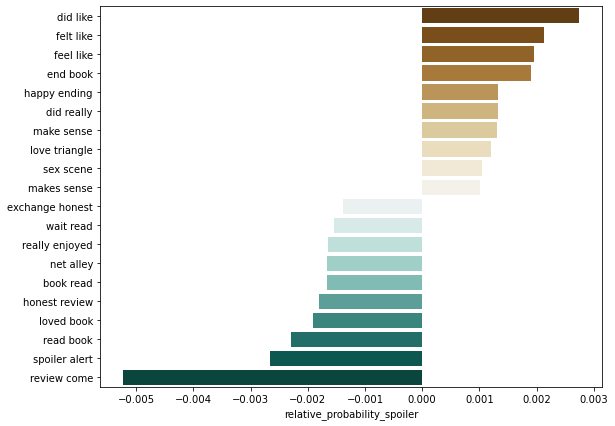

In [84]:
# importance of bigrams
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (2,2))

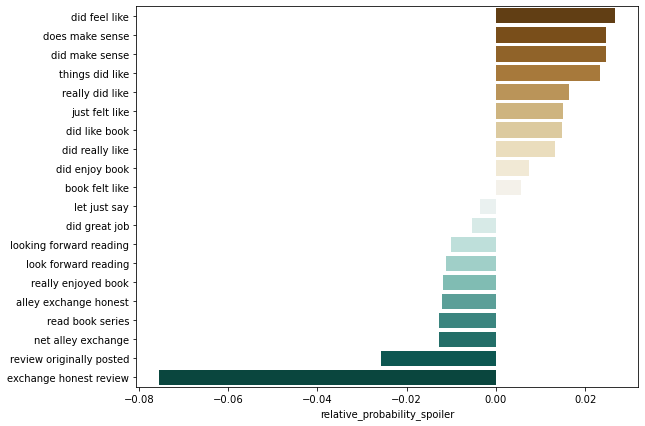

In [80]:
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (3,3))

In [7]:
# safe reviews ad labels, just in case
#with open('reviews.txt', 'w+') as rw:
#    json.dump(reviews, rw)

with open('review_labels.txt', 'w+') as rl:
    json.dump(labels_all, rl)
    
# to open:
with open('reviews.txt', 'r') as rw:
    reviews = json.load(rw)

125630

In [55]:
t0 = time.time()
reviews_l = [lemmatizer(r) for r in tqdm(reviews)]
elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

100%|██████████| 125630/125630 [1:18:16<00:00, 26.75it/s]  


'01:18:16'

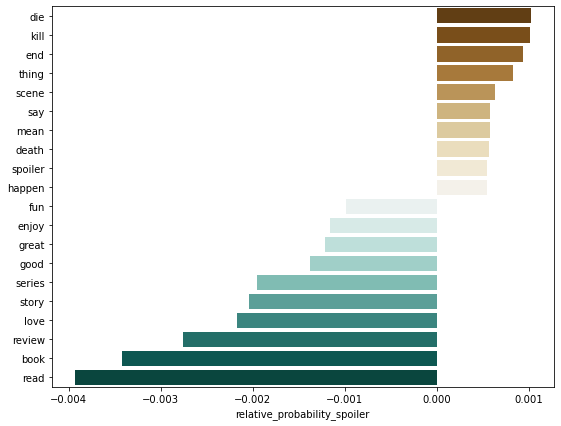

In [81]:
important_features_MB(reviews_l, labels_all,vectorizer = 'T', stop_words = None, ngram = (1,1))

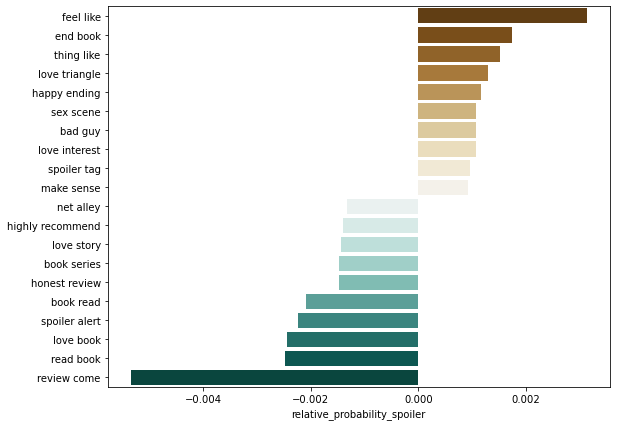

In [83]:
important_features_MB(reviews_l, labels_all,vectorizer = 'T', stop_words = None, ngram = (2,2))

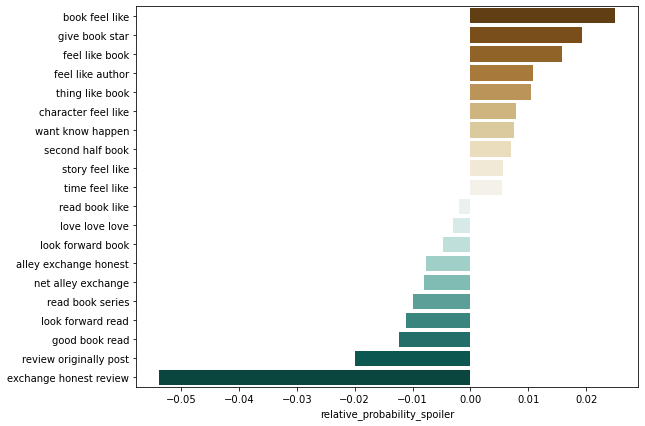

In [82]:
important_features_MB(reviews_l, labels_all,vectorizer = 'T', stop_words = None, ngram = (3,3))

### K-Means clustering of reviews

The idea behind K-means clustering here is to find out in a systematic, unsupervised way how close different reviews are.  
* 2 classes :spoiler vs non spoiler
* more classes: genre? 

In [3]:
with open('reviews_lemma.txt', 'r') as rw:
    reviews_l = json.load(rw)
rw.close()

In [4]:
num_reviews = int(len(reviews_l)/2)
labels_all = [0]*num_reviews + [1]*num_reviews

In [5]:
# get 10000 reviews 
df_reviews = pd.DataFrame({
    'review_text': reviews_l,
    'spoiler': labels_all
})
df_reviews_selection = df_reviews.sample(n = 10000, random_state = 42)


In [6]:
# get percentage of reviews with spoiler
np.mean(df_reviews_selection.spoiler)*100

49.120000000000005

In [10]:
# using the lemmatized full reviews as inputs

# words should appear at least 100 times
vectorizer = TfidfVectorizer(min_df = 100)
X = vectorizer.fit_transform(df_reviews_selection.review_text)
df_tfidf = pd.DataFrame(data = X.toarray(), columns = vectorizer.get_feature_names())


In [40]:
df_tfidf.shape

(10000, 1355)

The dataset contains of 1355 different words. We will only consider the 500 most important words for this test.

In [53]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=500).fit_transform(df_tfidf, df_reviews_selection.spoiler)
print(X_new.shape)
df_tfidf_new = pd.DataFrame(data = X_new)

(10000, 500)


In [28]:
from sklearn.cluster import KMeans

def kmean(max_k, data):
    kmeans_results = dict()
    for k in tqdm(range(2, max_k+1)):
        kmeans = KMeans(n_clusters = k,
                               init = 'k-means++',
                               n_init = 10,
                               tol = 0.0001,
                               random_state = 42,
                               algorithm = 'full')
        kmeans_results.update({k: kmeans.fit(data)})

    return kmeans_results

In [34]:
from sklearn import metrics

def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))

def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title((f"Silhouette analysis for K = {n_clusters}"), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = metrics.silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = metrics.silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)
    
    printAvg(avg_dict)

In [57]:
k = 10
kmeans_results = kmean(k, df_tfidf_new)

100%|██████████| 9/9 [00:53<00:00,  5.91s/it]


In [58]:
kmeans_results

{2: KMeans(algorithm='full', n_clusters=2, random_state=42),
 3: KMeans(algorithm='full', n_clusters=3, random_state=42),
 4: KMeans(algorithm='full', n_clusters=4, random_state=42),
 5: KMeans(algorithm='full', n_clusters=5, random_state=42),
 6: KMeans(algorithm='full', n_clusters=6, random_state=42),
 7: KMeans(algorithm='full', n_clusters=7, random_state=42),
 8: KMeans(algorithm='full', random_state=42),
 9: KMeans(algorithm='full', n_clusters=9, random_state=42),
 10: KMeans(algorithm='full', n_clusters=10, random_state=42)}

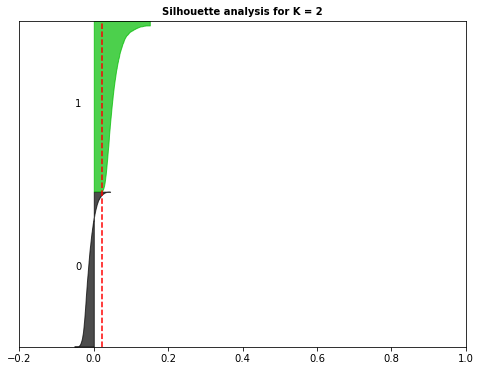

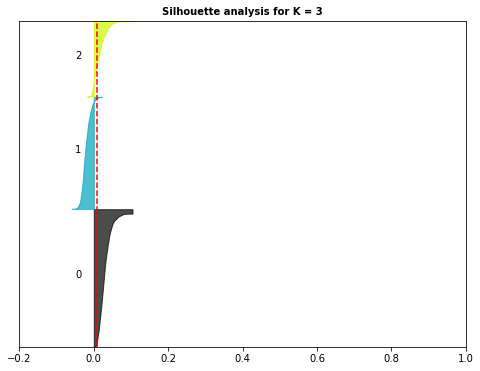

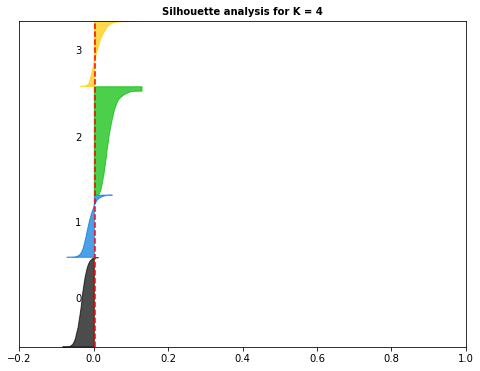

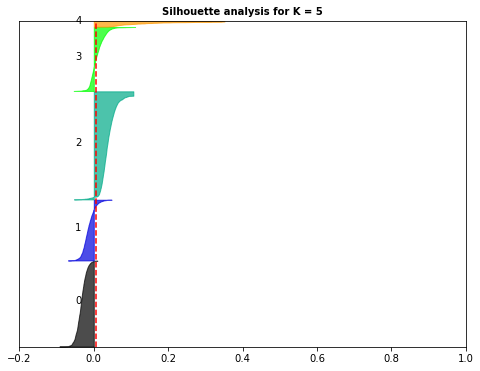

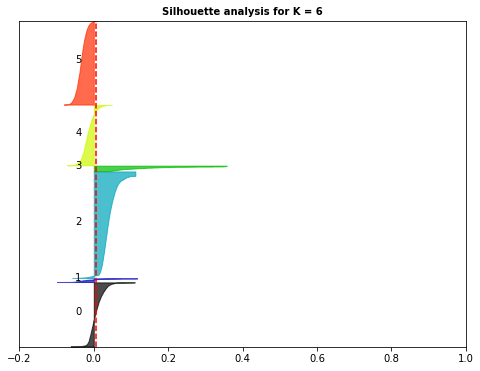

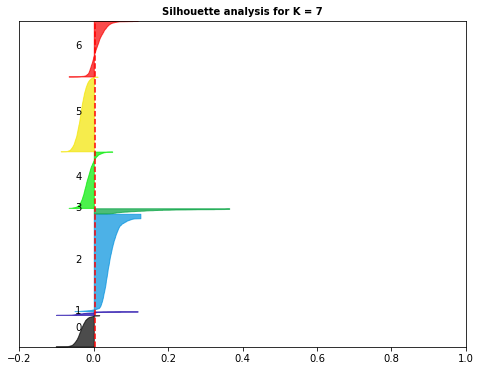

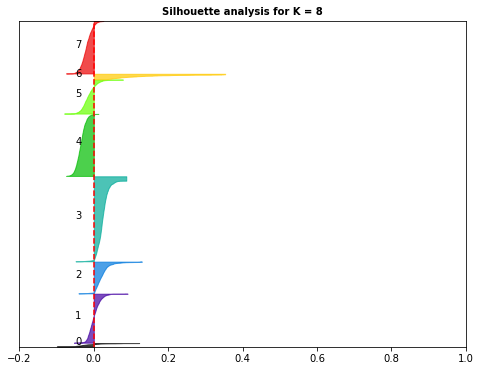

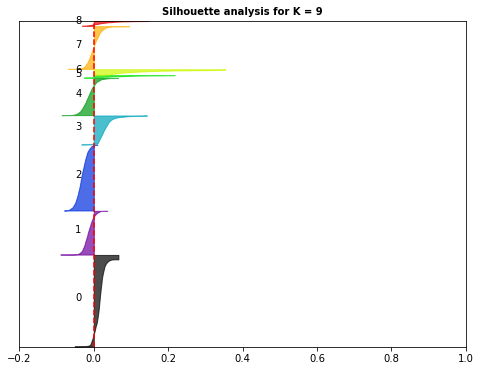

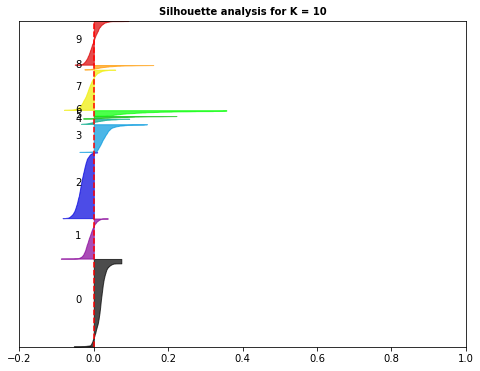

Avg: 0.0224	K:2
Avg: 0.009	K:3
Avg: 0.0052	K:6
Avg: 0.0052	K:5
Avg: 0.0042	K:4
Avg: 0.0028	K:7
Avg: 0.001	K:10
Avg: 0.0002	K:9
Avg: -0.0005	K:8


In [61]:
silhouette(kmeans_results, df_tfidf_new, plot=True)

The silhouette scores are very low and many reviews are likely put into wrong classes (negative score). This suggests that reviews are very heterogenous and even reviews for books of the same genre differ to much to be classified in one group by KMeans.

### Check classification of sentences containing spoilers


In [162]:
sentences_l = []
labels_l_s = []
with open('lemmatized_spoiler_review_sentences.txt', 'r') as sl:
    for line in sl:
        sentences_l.append(line.rstrip())
sl.close()
with open('lemmatized_spoiler_review_sentences_labels.txt', 'r') as ll:
    for line in ll:
        labels_l_s.append(int(line.rstrip()))
ll.close()

In [172]:
# sample sentences
df_spoiler_reviews_sentences = pd.DataFrame({
    'spoiler_review_sentences': sentences_l,
    'labels': labels
})
#df_spoiler_reviews_sentences_selection = df_spoiler_reviews_sentences.sample(n = 100000, random_state = 42)

In [71]:
vectorizer = TfidfVectorizer(min_df = 100)
X = vectorizer.fit_transform(df_spoiler_reviews_sentences_selection.spoiler_review_sentences)
df_tfidf = pd.DataFrame(data = X.toarray(), columns = vectorizer.get_feature_names())

In [72]:
k = 6
kmeans_results_spoiler = kmean(k, df_tfidf)

100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


In [74]:
silhouette(kmeans_results_spoiler, df_tfidf, plot=False)

In [ ]:
def sampling_vect(df, num_samples):
    
    vectorizer = TfidfVectorizer(min_df = 100)    
    df_dict = dict()
    for n in num_samples:
        df_s = df.sample(n = n, random_state = 42)
        X = vectorizer.fit_transform(df_s.spoiler_review_sentences)
        df_tfidf = pd.DataFrame(data = X.toarray(), columns = vectorizer.get_feature_names())
        df_dict.update({n: df_tfidf})
    return df_dict

In [228]:
def kmean(data_dict):
    kmeans_results = dict()
    
    for n, df in tqdm(data_dict.items()):
        kmeans = cluster.KMeans(n_clusters = 2,
                               init = 'k-means++',
                               n_init = 10,
                               tol = 0.0001,
                               random_state = 42,
                               algorithm = 'full')
        
        kmeans_results.update({n: kmeans.fit(df)})

    return kmeans_results

In [248]:
from sklearn import metrics 

def silhouette_n(kmean_dict, df_dict, plot = False):
    avg_dict = dict()
    accuracy_dict = dict()
    
    for n, alg in kmean_dict.items():
        df = df_dict[n]
        kmean_labels = alg.predict(df)
        silhouette_avg = metrics.silhouette_score(df, kmean_labels)
        avg_dict.update({n:silhouette_avg})
        print(f' The silhouette average score for {n} sentences is {silhouette_avg}')
        
        if plot == True:
            plotSilhouette(df, n, kmean_labels, silhouette_avg)
    
    for n,score in avg_dict.items():
        print(f' The silhouette average score for {n} sentences is {silhouette_avg}')
        
    #df = df.to_numpy()
    #avg_dict = dict()
    #for n_clusters, kmeans in kmeans_dict.items():      
    #    kmeans_labels = kmeans.predict(df)
    #    silhouette_avg = metrics.silhouette_score(df, kmeans_labels) # Average Score for all Samples
    #    avg_dict.update( {silhouette_avg : n_clusters})

In [246]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plotSilhouette(df, n, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    #fig.figsize((10,10))
    ax1.set_xlim([-0.2,1])
    # add 30 to insert blank space between the clusters
    ax1.set_ylim([0, len(df)+ 30])
    
    # add a vertical line for silhouette average
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--')
    # Clear the yaxis labels and define new tick labels
    ax1.set_yticks([])  
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title((f'Silhouette analysis for {n} sentences'), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = metrics.silhouette_samples(df, kmeans_labels)
    for i in range(2):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / 2)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()

In [229]:
df_samples = sampling_vect(df_spoiler_reviews_sentences,[10000, 25000, 50000, 100000])

In [225]:
for k, i in kmean_results.items():
    print(k, i)
for k, i in df_samples.items():
    print(k, df_samples[k].shape)

10000 KMeans(algorithm='full', n_clusters=2, random_state=42)
25000 KMeans(algorithm='full', n_clusters=2, random_state=42)
50000 KMeans(algorithm='full', n_clusters=2, random_state=42)
100000 KMeans(algorithm='full', n_clusters=2, random_state=42)
10000 (10000, 79)
25000 (25000, 244)
50000 (50000, 517)
100000 (100000, 982)


In [230]:
kmean_results = kmean(df_samples)

100%|██████████| 4/4 [00:21<00:00,  5.35s/it]


In [214]:
for n, i in kmean_results.items():
    print(n, i)

10000 KMeans(algorithm='full', n_clusters=2, random_state=42)
25000 KMeans(algorithm='full', n_clusters=2, random_state=42)
50000 KMeans(algorithm='full', n_clusters=2, random_state=42)
100000 KMeans(algorithm='full', n_clusters=2, random_state=42)


 The silhouette average score for 10000 sentences is 0.1326118694258348


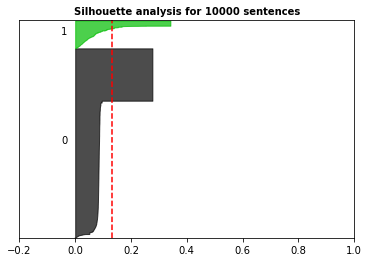

 The silhouette average score for 25000 sentences is 0.05914983161716603


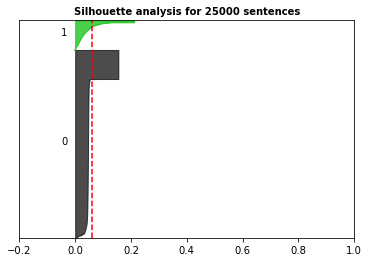

 The silhouette average score for 50000 sentences is 0.03684177037661878


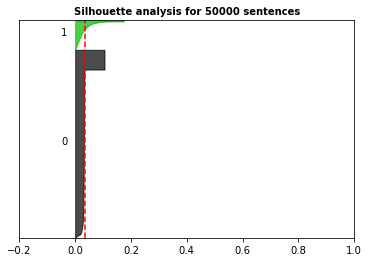

 The silhouette average score for 100000 sentences is 0.025875918084866494


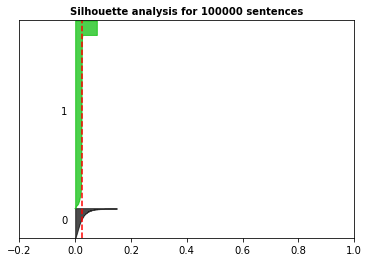

In [247]:
silhouette_n(kmean_results, df_samples)

In [250]:

df_samples = sampling_vect(df_spoiler_reviews_sentences,[1000, 2500, 5000, 10000, 25000, 50000, 100000])
kmean_results = kmean(df_samples)
silhouette_n(kmean_results, df_samples)

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


 The silhouette average score for 1000 sentences is 0.8352133565384977
 The silhouette average score for 2500 sentences is 0.4758312761679281
 The silhouette average score for 5000 sentences is 0.2782180569722904
 The silhouette average score for 10000 sentences is 0.1326118694258348
 The silhouette average score for 25000 sentences is 0.05914983161716603
 The silhouette average score for 50000 sentences is 0.03684177037661878
 The silhouette average score for 100000 sentences is 0.025875918084866494
 The silhouette average score for 1000 sentences is 0.025875918084866494
 The silhouette average score for 2500 sentences is 0.025875918084866494
 The silhouette average score for 5000 sentences is 0.025875918084866494
 The silhouette average score for 10000 sentences is 0.025875918084866494
 The silhouette average score for 25000 sentences is 0.025875918084866494
 The silhouette average score for 50000 sentences is 0.025875918084866494
 The silhouette average score for 100000 sentences is

With more sentences, the silhouette score declines drastically suggesting that sentences can not be classified very well. this makes sense given the heterogeneity of text and spoilers. Also take into consideration that the data set contains spoilers for several different genres including poems, crime and romance. 